In [1]:
cd ../..

c:\Users\Josu\Documents\Workspace\Human-Benchmark\src\server\model


In [ ]:
! del /q models\logs\*
! for /d %x in (models\logs\*) do @rd /get_model

In [ ]:
%load_ext tensorboard

In [2]:
import glob
from datetime import datetime
from os import path

import chess
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from tensorflow.keras import callbacks, models, utils

from scripts import bitboard

In [6]:
XX, yy_1, yy_2 = [], [], []
for file in glob.glob("data/npz/*/*.npz"):
    with np.load(file) as f:
        XX.append(f["X"]), yy_1.append(f["y_1"]), yy_2.append(f["y_2"])
X, y_1, y_2 = np.concatenate(XX), np.concatenate(yy_1), np.concatenate(yy_2)

In [7]:
X.shape, y_1.shape

((398898, 8, 8, 6), (398898,))

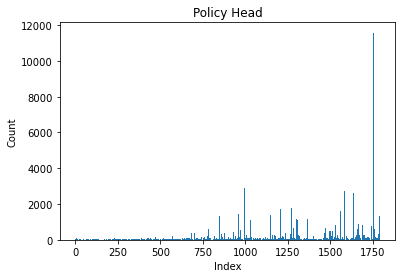

In [8]:
plt.title("Policy Head")
plt.xlabel("Index")
plt.ylabel("Count")
_ = plt.hist(y_1, bins=1858)

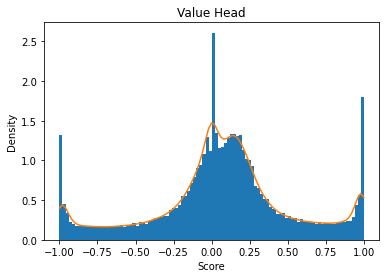

In [9]:
plt.title("Value Head")
plt.xlabel("Score")
plt.ylabel("Density")
_, x, _ = plt.hist(y_2, bins=100, density=True)  
_ = plt.plot(x,  stats.gaussian_kde(y_2)(x))

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Activation, Conv2D, Dense, Flatten,
                                     GlobalAveragePooling2D, Input, Lambda,
                                     ReLU, Reshape, add, multiply)


def policy_head(inputs: tf.Tensor, /) -> tf.Tensor:
    x = conv_block(inputs, filters=32)
    x = Flatten()(x)
    return Dense(1858, activation="softmax")(x)


def value_head(inputs: tf.Tensor, /) -> tf.Tensor:
    x = conv_block(inputs, filters=32)
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    return Dense(1, activation="tanh")(x)


def squeeze_and_exite(inputs: tf.Tensor, /, units: int) -> tf.Tensor:
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(32, activation="relu")(x)
    x = Dense(2 * units)(x)
    x = Reshape((2, units))(x)
    W, B = Lambda(tf.unstack, arguments={"axis": 1})(x)
    Z = Activation("sigmoid")(W)
    return add((multiply((Z, inputs)), B))


def conv_block(inputs: tf.Tensor, /, filters: int, *, units: int = None, skip_connection: tf.Tensor = None) -> tf.Tensor:
    x = Conv2D(filters, (3, 3), padding="same")(inputs)
    if units is not None:
        x = squeeze_and_exite(x, units=units)
    if skip_connection is not None:
        x = add((x, skip_connection))
    return ReLU()(x)


def residual_block(inputs: tf.Tensor, /, filters: int) -> tf.Tensor:
    x = conv_block(inputs, filters=filters)
    return conv_block(x, filters=filters, units=128, skip_connection=inputs)


def get_model() -> keras.Model:
    inputs = Input(shape=(8, 8, 6))
    x = conv_block(inputs, filters=128)
    for _ in range(1):
        x = residual_block(x, filters=128)
    outputs = policy_head(x), value_head(x)
    return keras.Model(inputs=inputs, outputs=outputs)

In [15]:
model = get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8, 8, 6)]    0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 8, 8, 128)    7040        input_2[0][0]                    
__________________________________________________________________________________________________
re_lu_23 (ReLU)                 (None, 8, 8, 128)    0           conv2d_23[0][0]                  
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 8, 8, 128)    147584      re_lu_23[0][0]                   
____________________________________________________________________________________________

In [ ]:
utils.plot_model(
    model,
    to_file=f"models/png/model.png",
    show_shapes=True,
    show_layer_names=False
)

In [ ]:
callback = (
    callbacks.TensorBoard(
        log_dir=f"models/logs/{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    ),
    callbacks.ModelCheckpoint(
        f"models/ser/{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    )
)

In [16]:
model.compile(
    optimizer="adam",
    loss=("sparse_categorical_crossentropy", "mse")
)

In [17]:
_ = model.fit(
    x=X, y=(y_1, y_2),
    batch_size=256,
    epochs=5,
    # callbacks=callback,
    validation_split=.2
)

Epoch 1/5
1247/1247 [==============================] - 926s 742ms/step - loss: 3.9047 - dense_25_loss: 3.7625 - dense_27_loss: 0.1422 - val_loss: 3.0460 - val_dense_25_loss: 2.9001 - val_dense_27_loss: 0.1459
Epoch 2/5
1247/1247 [==============================] - 920s 738ms/step - loss: 2.5107 - dense_25_loss: 2.3948 - dense_27_loss: 0.1159 - val_loss: 2.8991 - val_dense_25_loss: 2.7726 - val_dense_27_loss: 0.1265
Epoch 3/5
1247/1247 [==============================] - 921s 739ms/step - loss: 2.0369 - dense_25_loss: 1.9308 - dense_27_loss: 0.1061 - val_loss: 2.9991 - val_dense_25_loss: 2.8752 - val_dense_27_loss: 0.1239
Epoch 4/5
1247/1247 [==============================] - 903s 724ms/step - loss: 1.7076 - dense_25_loss: 1.6076 - dense_27_loss: 0.1001 - val_loss: 3.1770 - val_dense_25_loss: 3.0655 - val_dense_27_loss: 0.1115
Epoch 5/5
1247/1247 [==============================] - 957s 767ms/step - loss: 1.4749 - dense_25_loss: 1.3796 - dense_27_loss: 0.0954 - val_loss: 3.5209 - val_dense

In [18]:
model.save("models/ser/v1")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/ser/v1\assets


In [ ]:
%tensorboard --logdir models/logs

In [19]:
board = chess.Board(chess.STARTING_FEN)

In [131]:
y_ = model.predict(np.array([bitboard(board)]))
y_

(array([[1.3455976e-13, 3.8255380e-13, 2.2517993e-08, ..., 1.4356875e-10,
         2.8834118e-10, 1.2181874e-10]], dtype=float32),
 array([[-0.10514585]], dtype=float32))

In [132]:
moves = np.array(moves)
moves[np.argsort(-y_[0])][:, :5]

array([['e6d5', 'e6e5', 'e8g8', 'b6d4', 'f5f4']], dtype='<U5')

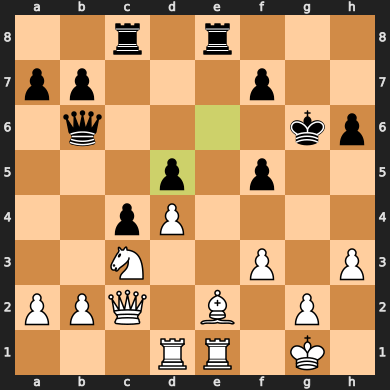

In [133]:
board.push_uci("e6d5")
# board.pop()
board

In [134]:
board.fen()

'2r1r3/pp3p2/1q4kp/3p1p2/2pP4/2N2P1P/PPQ1B1P1/3RR1K1 w - - 0 24'